<a href="https://colab.research.google.com/github/ashaduzzaman-sarker/Image-Classification/blob/main/Semi_supervised_image_classification_using_contrastive_pretraining_with_SimCLR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Semi-supervised image classification using contrastive pretraining with SimCLR on the STL-10 dataset.

**Author:**[Ashaduzzaman Sarker](https://github.com/ashaduzzaman-sarker/)
<br>
**Date created:** 25/06/24
<br>
**Reference:** [Keras Example](https://keras.io/examples/vision/semisupervised_simclr/)

## Introduction to Semi-Supervised Learning and Contrastive Learning

#### Semi-Supervised Learning:
- **Definition**: Utilizes both labeled and unlabeled data for training.
- **Advantage**: Reduces the need for large amounts of labeled data, which are expensive and time-consuming to acquire.
- **Efficiency**: Enhances label efficiency by leveraging abundant and inexpensive unlabeled data.
- **Application Example**: Pretraining an encoder with contrastive learning on the STL-10 dataset (using no labels) and fine-tuning it with the labeled subset.

#### Contrastive Learning:
- **Goal**: Learn representations invariant to augmentations in a self-supervised manner.
- **Challenge**: Avoiding degenerate solutions where representations are constant and non-informative.
- **Objective Modification**: Pulls representations of augmented versions of the same image closer (contracting positives) and pushes different images apart (contrasting negatives).

##### Key Approaches:
1. **SimCLR**:
   - Identifies core components for optimizing contrastive learning objectives.
   - Achieves high performance by scaling the approach.
   - Contracts representations of the same image's augmentations and contrasts different images.

2. **SimSiam**:
   - Does not use negatives in its loss function.
   - Avoids trivial solutions through architecture design (asymmetric encoding paths, predictor network, batch normalization).
   - Implicitly ensures meaningful representation learning without explicitly contrasting negatives.


## Imports

In [1]:
!pip install --upgrade keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 11.3 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.4.0 which is incompatible.


In [2]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"


# Make sure we are able to handle large datasets
import resource

low, high = resource.getrlimit(resource.RLIMIT_NOFILE)
resource.setrlimit(resource.RLIMIT_NOFILE, (high, high))

import math
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds

import keras
from keras import ops
from keras import layers

## Hyperparameter setup

In [3]:
# Dataset hyperparameters
unlabeled_dataset_size = 100000
labeled_dataset_size = 5000
image_channels = 3

# Algorithm hyperparameters
num_epochs = 20
batch_size = 525  # Corresponds to 200 steps per epoch
width = 128
temperature = 0.1

# Stronger augmentations for contrastive, weaker ones for supervised training
contrastive_augmentation = {
    "min_area": 0.25,
    "brightness": 0.6,
    "jitter": 0.2}

classification_augmentation = {
    "min_area": 0.75,
    "brightness": 0.3,
    "jitter": 0.1,
}

## Dataset

> During training we will simultaneously load a large batch of unlabeled images along with a smaller batch of labeled images

In [4]:
def prepare_dataset():
    # Labeled and unlabeled samples are loaded synchronously with batch sizes selected accordingly
    steps_per_epoch = (unlabeled_dataset_size + labeled_dataset_size) // batch_size
    unlabeled_batch_size = unlabeled_dataset_size // steps_per_epoch
    labeled_batch_size = labeled_dataset_size // steps_per_epoch
    print(
        f"batch size is {unlabeled_batch_size} (unlabeled) + {labeled_batch_size} (labeled)"
    )

    # Turning off shuffle to lower resource usage
    unlabeled_train_dataset = (
        tfds.load("stl10", split="unlabelled", as_supervised=True, shuffle_files=False)
        .shuffle(buffer_size=10 * unlabeled_batch_size)
        .batch(unlabeled_batch_size)
    )

    labeled_train_dataset = (
        tfds.load("stl10", split="train", as_supervised=True, shuffle_files=False)
        .shuffle(buffer_size=10 * labeled_batch_size)
        .batch(labeled_batch_size)
    )

    test_dataset = (
        tfds.load("stl10", split="test", as_supervised=True)
        .batch(batch_size)
        .prefetch(buffer_size=tf.data.AUTOTUNE)
    )

    # Labeled and unlabeled datasets are zipped together
    train_dataset = tf.data.Dataset.zip(
        (unlabeled_train_dataset, labeled_train_dataset)
    ).prefetch(buffer_size=tf.data.AUTOTUNE)

    return train_dataset, labeled_train_dataset, test_dataset


# Load STL10 dataset
train_dataset, labeled_train_dataset, test_dataset = prepare_dataset()

batch size is 500 (unlabeled) + 25 (labeled)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/5000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/stl10/incomplete.VTGXKH_1.0.0/stl10-train.tfrecord*...:   0%|          | 0…

Generating test examples...:   0%|          | 0/8000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/stl10/incomplete.VTGXKH_1.0.0/stl10-test.tfrecord*...:   0%|          | 0/…

Generating unlabelled examples...:   0%|          | 0/100000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/stl10/incomplete.VTGXKH_1.0.0/stl10-unlabelled.tfrecord*...:   0%|        …

Dataset stl10 downloaded and prepared to /root/tensorflow_datasets/stl10/1.0.0. Subsequent calls will reuse this data.


## Image augmentations

### Key Points on Image Augmentations for Contrastive Learning

1. **Important Augmentations**:
    - **Cropping**:
        - **Purpose**: Forces the model to encode different parts of the same image similarly.
        - **Implementation**: Achieved using `RandomTranslation` and `RandomZoom` layers.
    - **Color Jitter**:
        - **Purpose**: Prevents trivial color histogram-based solutions by distorting color histograms.
        - **Implementation**: Implemented through affine transformations in color space.

2. **Additional Augmentations**:
    - **Random Horizontal Flips**: Used alongside stronger augmentations for contrastive learning and weaker ones for supervised classification to avoid overfitting on the few labeled examples.

3. **Implementation Advantages**:
    - **Custom Preprocessing Layer**: Random color jitter implemented as a custom preprocessing layer.
    - **GPU Utilization**: Data augmentation runs on GPU in batches, preventing training bottlenecks due to constrained CPU resources.
    - **Simplified Deployment**: The preprocessing pipeline is encapsulated within the model, simplifying deployment as it does not need to be reimplemented.

In [5]:
# Distorts the color distibutions of images
class RandomColorAffine(layers.Layer):
    def __init__(self, brightness=0, jitter=0, **kwargs):
        super().__init__(**kwargs)

        self.seed_generator = keras.random.SeedGenerator(1337)
        self.brightness = brightness
        self.jitter = jitter

    def get_config(self):
        config = super().get_config()
        config.update({"brightness": self.brightness, "jitter": self.jitter})
        return config

    def call(self, images, training=True):
        if training:
            batch_size = ops.shape(images)[0]

            # Same for all colors
            brightness_scales = 1 + keras.random.uniform(
                (batch_size, 1, 1, 1),
                minval=-self.brightness,
                maxval=self.brightness,
                seed=self.seed_generator,
            )
            # Different for all colors
            jitter_matrices = keras.random.uniform(
                (batch_size, 1, 3, 3),
                minval=-self.jitter,
                maxval=self.jitter,
                seed=self.seed_generator,
            )

            color_transforms = (
                ops.tile(ops.expand_dims(ops.eye(3), axis=0), (batch_size, 1, 1, 1))
                * brightness_scales
                + jitter_matrices
            )
            images = ops.clip(ops.matmul(images, color_transforms), 0, 1)
        return images

In [6]:
# Image augmentation module
def get_augmenter(min_area, brightness, jitter):
    zoom_factor = 1.0 - math.sqrt(min_area)
    return keras.Sequential(
        [
            layers.Rescaling(1 / 255),
            layers.RandomFlip("horizontal"),
            layers.RandomTranslation(zoom_factor / 2, zoom_factor / 2),
            layers.RandomZoom((-zoom_factor, 0.0), (-zoom_factor, 0.0)),
            RandomColorAffine(brightness, jitter),
        ]
    )

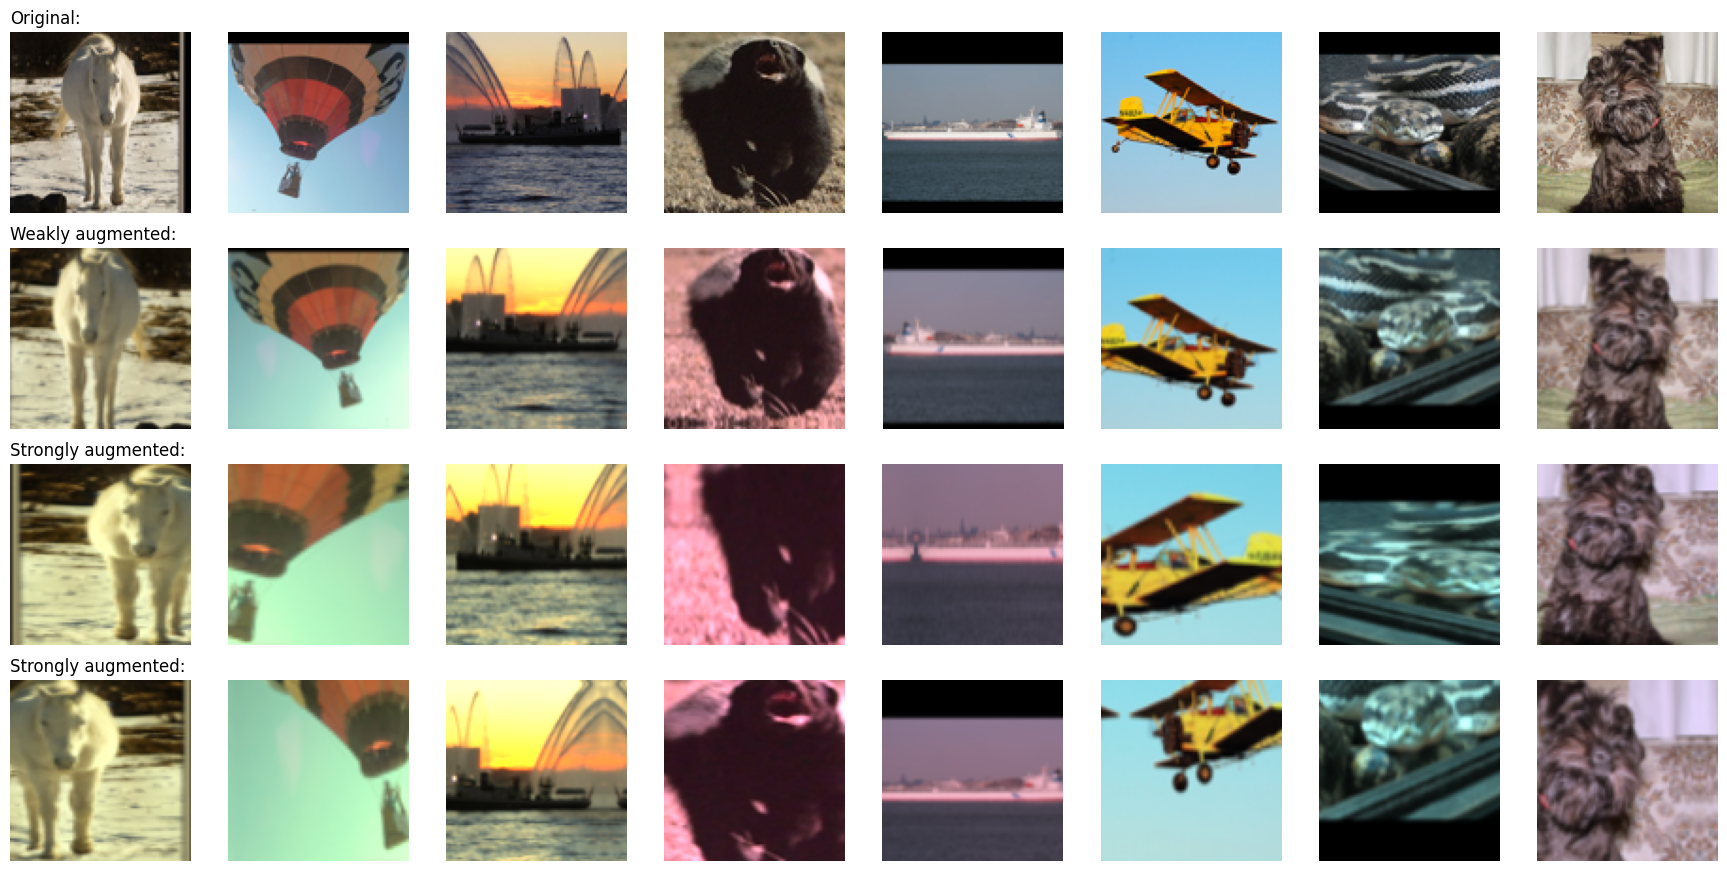

In [7]:
def visualize_augmentations(num_images):
    # Sample a batch from a dataset
    images = next(iter(train_dataset))[0][0][:num_images]

    # Apply augmentations
    augmented_images = zip(
        images,
        get_augmenter(**classification_augmentation)(images),
        get_augmenter(**contrastive_augmentation)(images),
        get_augmenter(**contrastive_augmentation)(images),
    )
    row_titles = [
        "Original:",
        "Weakly augmented:",
        "Strongly augmented:",
        "Strongly augmented:",
    ]
    plt.figure(figsize=(num_images * 2.2, 4 * 2.2), dpi=100)
    for column, image_row in enumerate(augmented_images):
        for row, image in enumerate(image_row):
            plt.subplot(4, num_images, row * num_images + column + 1)
            plt.imshow(image)
            if column == 0:
                plt.title(row_titles[row], loc="left")
            plt.axis("off")
    plt.tight_layout()


visualize_augmentations(num_images=8)

## Encoder architecture
The architecture of transformer encoder:
- (a) encoder architecture;
- (b) multi-head attention;
- (c) scaled dot-product attention
![](https://www.researchgate.net/publication/358663304/figure/fig3/AS:1127510674804738@1645830901731/The-architecture-of-transformer-encoder-a-encoder-architecture-b-multi-head.png)

In [9]:
# Define the encoder architecture
def get_encoder():
    return keras.Sequential(
        [
            layers.Conv2D(width, kernel_size=3, strides=2, activation="relu"),
            layers.Conv2D(width, kernel_size=3, strides=2, activation="relu"),
            layers.Conv2D(width, kernel_size=3, strides=2, activation="relu"),
            layers.Conv2D(width, kernel_size=3, strides=2, activation="relu"),
            layers.Flatten(),
            layers.Dense(width, activation="relu"),
        ],
        name="encoder",
    )

## Supervised baseline model

In [10]:
# Baseline supervised training with random initialization
baseline_model = keras.Sequential(
    [
        get_augmenter(**classification_augmentation),
        get_encoder(),
        layers.Dense(10),
    ],
    name="baseline_model",
)

baseline_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
)

baseline_history = baseline_model.fit(
    labeled_train_dataset, epochs=num_epochs, validation_data=test_dataset
)

print(
    "Maximal validation accuracy: {:.2f}%".format(
        max(baseline_history.history["val_acc"]) * 100
    )
)

Epoch 1/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 15s 48ms/step - acc: 0.1768 - loss: 2.1764 - val_acc: 0.3370 - val_loss: 1.6871
Epoch 2/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - acc: 0.3509 - loss: 1.7383 - val_acc: 0.4055 - val_loss: 1.5680
Epoch 3/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - acc: 0.3982 - loss: 1.6407 - val_acc: 0.4081 - val_loss: 1.5943
Epoch 4/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - acc: 0.4138 - loss: 1.5664 - val_acc: 0.4631 - val_loss: 1.4373
Epoch 5/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - acc: 0.4553 - loss: 1.4494 - val_acc: 0.4930 - val_loss: 1.3791
Epoch 6/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - acc: 0.4873 - loss: 1.3742 - val_acc: 0.5086 - val_loss: 1.3216
Epoch 7/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - acc: 0.5132 - loss: 1.3013 - val_acc: 0.5389 - val_loss: 1.2616
Epoch 8/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - acc: 0.5308 - loss: 1.2352 - val_acc: 0.5491 - val_loss: 1.2419
Epoch 9/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 4

## Self-supervised model for contrastive pretraining

1. **Contrastive Pretraining**:
    - **Objective**: Pretrain an encoder on unlabeled images using contrastive loss.
    - **Projection Head**: A nonlinear projection head is attached to the encoder to enhance representation quality.

2. **Loss Function**:
    - **InfoNCE/NT-Xent/N-pairs Loss**:
        - **Class Treatment**: Each image in the batch is treated as its own class.
        - **Pairing**: Two augmented views for each "class".
        - **Comparison**: Each view's representation is compared to every possible pair’s representation.
        - **Similarity Measure**: Temperature-scaled cosine similarity of representations used as logits.
        - **Loss Calculation**: Categorical cross-entropy is used as the "classification" loss.

3. **Pretraining Performance Metrics**:
    - **Contrastive Accuracy**:
        - **Definition**: The ratio of cases where an image's representation is more similar to its differently augmented version than to any other image in the batch.
        - **Usage**: Used for hyperparameter tuning, even without labeled examples.
    - **Linear Probing Accuracy**:
        - **Definition**: Accuracy of a logistic regression classifier trained on the encoder's features.
        - **Implementation**: Involves training a single dense layer on top of the frozen encoder during pretraining to monitor its value, aiding in experimentation and debugging.
    - **KNN Accuracy** (Not implemented in this example):
        - **Definition**: Accuracy of a KNN classifier trained on the encoder's features.
        - **Usage**: A common supervised metric to evaluate self-supervised classifiers.

In [11]:
# Define the contrastive model with model-subclassing
class ContrastiveModel(keras.Model):
    def __init__(self):
        super().__init__()

        self.temperature = temperature
        self.contrastive_augmenter = get_augmenter(**contrastive_augmentation)
        self.classification_augmenter = get_augmenter(**classification_augmentation)
        self.encoder = get_encoder()
        # Non-linear MLP as projection head
        self.projection_head = keras.Sequential(
            [
                keras.Input(shape=(width,)),
                layers.Dense(width, activation="relu"),
                layers.Dense(width),
            ],
            name="projection_head",
        )
        # Single dense layer for linear probing
        self.linear_probe = keras.Sequential(
            [layers.Input(shape=(width,)), layers.Dense(10)],
            name="linear_probe",
        )

        self.encoder.summary()
        self.projection_head.summary()
        self.linear_probe.summary()

    def compile(self, contrastive_optimizer, probe_optimizer, **kwargs):
        super().compile(**kwargs)

        self.contrastive_optimizer = contrastive_optimizer
        self.probe_optimizer = probe_optimizer

        # self.contrastive_loss will be defined as a method
        self.probe_loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

        self.contrastive_loss_tracker = keras.metrics.Mean(name="c_loss")
        self.contrastive_accuracy = keras.metrics.SparseCategoricalAccuracy(
            name="c_acc"
        )
        self.probe_loss_tracker = keras.metrics.Mean(name="p_loss")
        self.probe_accuracy = keras.metrics.SparseCategoricalAccuracy(name="p_acc")

    @property
    def metrics(self):
        return [
            self.contrastive_loss_tracker,
            self.contrastive_accuracy,
            self.probe_loss_tracker,
            self.probe_accuracy,
        ]

    def contrastive_loss(self, projections_1, projections_2):
        # InfoNCE loss (information noise-contrastive estimation)
        # NT-Xent loss (normalized temperature-scaled cross entropy)

        # Cosine similarity: the dot product of the l2-normalized feature vectors
        projections_1 = ops.normalize(projections_1, axis=1)
        projections_2 = ops.normalize(projections_2, axis=1)
        similarities = (
            ops.matmul(projections_1, ops.transpose(projections_2)) / self.temperature
        )

        # The similarity between the representations of two augmented views of the
        # same image should be higher than their similarity with other views
        batch_size = ops.shape(projections_1)[0]
        contrastive_labels = ops.arange(batch_size)
        self.contrastive_accuracy.update_state(contrastive_labels, similarities)
        self.contrastive_accuracy.update_state(
            contrastive_labels, ops.transpose(similarities)
        )

        # The temperature-scaled similarities are used as logits for cross-entropy
        # a symmetrized version of the loss is used here
        loss_1_2 = keras.losses.sparse_categorical_crossentropy(
            contrastive_labels, similarities, from_logits=True
        )
        loss_2_1 = keras.losses.sparse_categorical_crossentropy(
            contrastive_labels, ops.transpose(similarities), from_logits=True
        )
        return (loss_1_2 + loss_2_1) / 2

    def train_step(self, data):
        (unlabeled_images, _), (labeled_images, labels) = data

        # Both labeled and unlabeled images are used, without labels
        images = ops.concatenate((unlabeled_images, labeled_images), axis=0)
        # Each image is augmented twice, differently
        augmented_images_1 = self.contrastive_augmenter(images, training=True)
        augmented_images_2 = self.contrastive_augmenter(images, training=True)
        with tf.GradientTape() as tape:
            features_1 = self.encoder(augmented_images_1, training=True)
            features_2 = self.encoder(augmented_images_2, training=True)
            # The representations are passed through a projection mlp
            projections_1 = self.projection_head(features_1, training=True)
            projections_2 = self.projection_head(features_2, training=True)
            contrastive_loss = self.contrastive_loss(projections_1, projections_2)
        gradients = tape.gradient(
            contrastive_loss,
            self.encoder.trainable_weights + self.projection_head.trainable_weights,
        )
        self.contrastive_optimizer.apply_gradients(
            zip(
                gradients,
                self.encoder.trainable_weights + self.projection_head.trainable_weights,
            )
        )
        self.contrastive_loss_tracker.update_state(contrastive_loss)

        # Labels are only used in evalutation for an on-the-fly logistic regression
        preprocessed_images = self.classification_augmenter(
            labeled_images, training=True
        )
        with tf.GradientTape() as tape:
            # the encoder is used in inference mode here to avoid regularization
            # and updating the batch normalization paramers if they are used
            features = self.encoder(preprocessed_images, training=False)
            class_logits = self.linear_probe(features, training=True)
            probe_loss = self.probe_loss(labels, class_logits)
        gradients = tape.gradient(probe_loss, self.linear_probe.trainable_weights)
        self.probe_optimizer.apply_gradients(
            zip(gradients, self.linear_probe.trainable_weights)
        )
        self.probe_loss_tracker.update_state(probe_loss)
        self.probe_accuracy.update_state(labels, class_logits)

        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        labeled_images, labels = data

        # For testing the components are used with a training=False flag
        preprocessed_images = self.classification_augmenter(
            labeled_images, training=False
        )
        features = self.encoder(preprocessed_images, training=False)
        class_logits = self.linear_probe(features, training=False)
        probe_loss = self.probe_loss(labels, class_logits)
        self.probe_loss_tracker.update_state(probe_loss)
        self.probe_accuracy.update_state(labels, class_logits)

        # Only the probe metrics are logged at test time
        return {m.name: m.result() for m in self.metrics[2:]}

In [12]:
# Contrastive pretraining
pretraining_model = ContrastiveModel()
pretraining_model.compile(
    contrastive_optimizer=keras.optimizers.Adam(),
    probe_optimizer=keras.optimizers.Adam(),
)

pretraining_history = pretraining_model.fit(
    train_dataset, epochs=num_epochs, validation_data=test_dataset
)
print(
    "Maximal validation accuracy: {:.2f}%".format(
        max(pretraining_history.history["val_p_acc"]) * 100
    )
)

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Model: "projection_head"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          16,512 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,024 (129.00 KB)

 Trainable params: 33,024 (129.00 KB)

 Non-trainable params: 0 (0.00 B)

Model: "linear_probe"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,290 (5.04 KB)

 Trainable params: 1,290 (5.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 95s 420ms/step - c_acc: 0.0849 - c_loss: 5.3145 - p_acc: 0.1581 - p_loss: 2.2930 - val_p_acc: 0.2946 - val_p_loss: 2.0624
Epoch 2/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 136s 401ms/step - c_acc: 0.2808 - c_loss: 3.6344 - p_acc: 0.3131 - p_loss: 2.0329 - val_p_acc: 0.3345 - val_p_loss: 1.9521
Epoch 3/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 83s 406ms/step - c_acc: 0.4129 - c_loss: 2.9323 - p_acc: 0.3618 - p_loss: 1.8929 - val_p_acc: 0.3668 - val_p_loss: 1.8224
Epoch 4/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 142s 406ms/step - c_acc: 0.4748 - c_loss: 2.6234 - p_acc: 0.3980 - p_loss: 1.7684 - val_p_acc: 0.4066 - val_p_loss: 1.7107
Epoch 5/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 83s 402ms/step - c_acc: 0.5352 - c_loss: 2.3478 - p_acc: 0.4155 - p_loss: 1.6751 - val_p_acc: 0.4141 - val_p_loss: 1.6471
Epoch 6/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 141s 396ms/step - c_acc: 0.5717 - c_loss: 2.1896 - p_acc: 0.4242 - p_loss: 1.6233 - val_p_acc: 0.4409 - val_p_loss: 1.5802
Epoch 7/20
200/200 ━━━━━━

## Supervised finetuning of the pretrained encoder

In [14]:
# Supervised finetuning of the pretrained encoder
finetuning_model = keras.Sequential(
    [
        get_augmenter(**classification_augmentation),
        pretraining_model.encoder,
        layers.Dense(10),
    ],
    name="finetuning_model",
)
finetuning_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
)

finetuning_history = finetuning_model.fit(
    labeled_train_dataset, epochs=num_epochs, validation_data=test_dataset
)
print(
    "Maximal validation accuracy: {:.2f}%".format(
        max(finetuning_history.history["val_acc"]) * 100
    )
)

Epoch 1/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - acc: 0.2307 - loss: 2.0614 - val_acc: 0.4125 - val_loss: 1.5301
Epoch 2/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - acc: 0.4422 - loss: 1.4844 - val_acc: 0.4678 - val_loss: 1.4593
Epoch 3/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - acc: 0.5154 - loss: 1.3162 - val_acc: 0.5560 - val_loss: 1.2261
Epoch 4/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - acc: 0.5479 - loss: 1.2322 - val_acc: 0.5452 - val_loss: 1.3026
Epoch 5/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - acc: 0.5954 - loss: 1.1358 - val_acc: 0.5947 - val_loss: 1.1421
Epoch 6/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - acc: 0.6168 - loss: 1.0815 - val_acc: 0.5960 - val_loss: 1.1211
Epoch 7/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - acc: 0.6377 - loss: 1.0114 - val_acc: 0.6049 - val_loss: 1.0822
Epoch 8/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - acc: 0.6380 - loss: 0.9985 - val_acc: 0.6068 - val_loss: 1.1204
Epoch 9/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 7s 3

## Comparison against the baseline

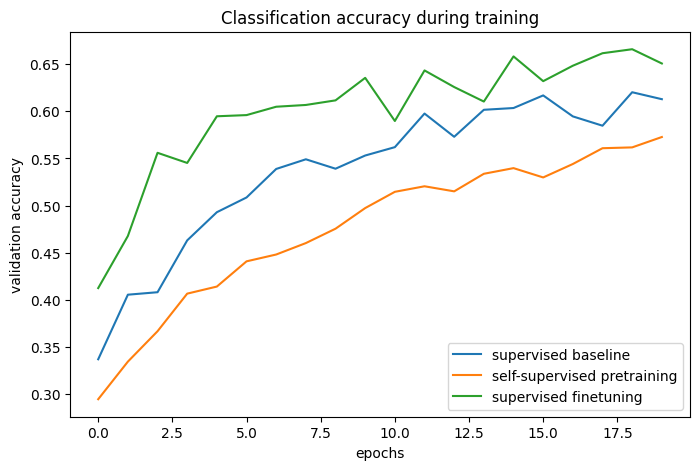

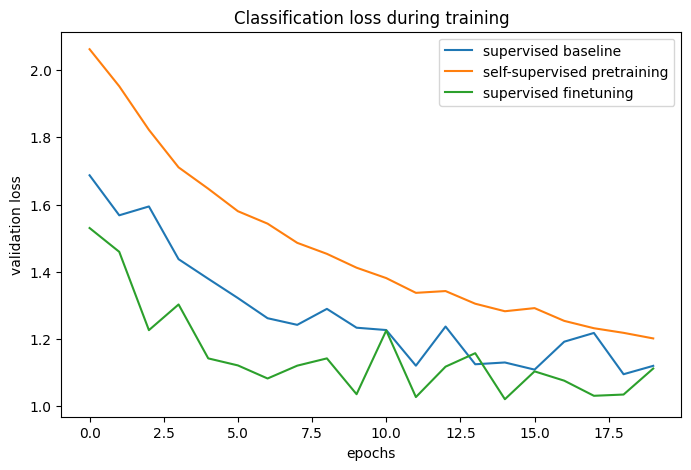

In [15]:
# The classification accuracies of the baseline and the pretraining + finetuning process:
def plot_training_curves(pretraining_history, finetuning_history, baseline_history):
    for metric_key, metric_name in zip(["acc", "loss"], ["accuracy", "loss"]):
        plt.figure(figsize=(8, 5), dpi=100)
        plt.plot(
            baseline_history.history[f"val_{metric_key}"],
            label="supervised baseline",
        )
        plt.plot(
            pretraining_history.history[f"val_p_{metric_key}"],
            label="self-supervised pretraining",
        )
        plt.plot(
            finetuning_history.history[f"val_{metric_key}"],
            label="supervised finetuning",
        )
        plt.legend()
        plt.title(f"Classification {metric_name} during training")
        plt.xlabel("epochs")
        plt.ylabel(f"validation {metric_name}")


plot_training_curves(pretraining_history, finetuning_history, baseline_history)